# Intelligent Agents: Reflex Agents for the Vacuum-cleaner World


## Instructions

Total Points: undergrad 10, graduate students 11

Complete this notebook and submit it. The notebook needs to be a complete project report with 

* your implementation (you can use libraries like math, numpy, scipy, but not libraries that implement inteligent agents or search algorithms),
* documentation including a short discussion of how your implementation works and your design choices, and
* experimental results (e.g., tables and charts with simulation results) with a short discussion of what they mean. 

Use the provided notebook cells and insert additional code and markdown cells as needed.

## Introduction

In this assignment you will implement a simulator environment for an automatic vacuum cleaner robot, a set of different reflex agent programs, and perform a comparison study for cleaning a single room. Focus on the __cleaning phase__ which starts when the robot is activated and ends when the last dirty square is cleaned. Someone else will take care of the agent program needed to navigate back to the charging station after the room is clean.

## PEAS description of the cleaning phase

__Performance Measure:__ Each action costs 1 energy unit. The performance is measured as the sum of the energy units used to clean the whole room.

__Environment:__ A room with $n \times n$ squares where $n = 5$. Dirt is randomly placed on each square with probability $p = 0.2$. For simplicity, you can assume that the agent knows the size and the layout of the room (i.e., it knows $n$). To start, the agent is placed on a random square.

__Actuators:__ The agent can clean the current square (action `suck`) or move to an adjacent square by going `north`, `east`, `south`, or `west`.

__Sensors:__ Four bumper sensors, one for north, east, south, and west; a dirt sensor reporting dirt in the current square.  


## The agent program for a simple randomized agent

The agent program is a function that gets sensor information (the current percepts) as the arguments. The arguments are:

* A dictionary with boolean entries for the for bumper sensors `north`, `east`, `west`, `south`. E.g., if the agent is on the north-west corner, `bumpers` will be `{"north" : True, "east" : False, "south" : False, "west" : True}`.
* The dirt sensor produces a boolean.

The agent returns the chosen action as a string.

Here is an example implementation for the agent program of a simple randomized agent:  

In [11]:
import numpy as np

actions = ["north", "east", "west", "south", "suck"]

def simple_randomized_agent(bumpers, dirty):
    return np.random.choice(actions)

In [12]:
# define percepts (current location is NW corner and it is dirty)
bumpers = {"north" : True, "east" : False, "south" : False, "west" : True}
dirty = True

# call agent program function with percepts and it returns an action
simple_randomized_agent(bumpers, dirty)

'suck'

__Note:__ This is not a rational intelligent agent. It ignores its sensors and may bump into a wall repeatedly or not clean a dirty square. You will be asked to implement rational agents below.

## Simple environment example

We implement a simple simulation environment that supplies the agent with its percepts.
The simple environment is infinite in size (bumpers are always `False`) and every square is always dirty, even if the agent cleans it. The environment function returns a performance measure which is here the number of cleaned squares (since the room is infinite and all squares are constantly dirty, the agent can never clean the whole room as required in the PEAS description above). The energy budget of the agent is specified as `max_steps`. 

In [13]:
def simple_environment(agent, max_steps, verbose = True):
    num_cleaned = 0
    
    for i in range(max_steps):
        dirty = True
        bumpers = {"north" : False, "south" : False, "west" : False, "east" : False}

        action = agent(bumpers, dirty)
        if (verbose): print("step", i , "- action:", action) 
        
        if (action == "suck"): 
            num_cleaned = num_cleaned + 1
        
    return num_cleaned
        


Do one simulation run with a simple randomized agent that has enough energy for 20 steps.

In [14]:
simple_environment(simple_randomized_agent, max_steps = 20)

step 0 - action: north
step 1 - action: suck
step 2 - action: east
step 3 - action: north
step 4 - action: suck
step 5 - action: south
step 6 - action: south
step 7 - action: suck
step 8 - action: west
step 9 - action: north
step 10 - action: west
step 11 - action: north
step 12 - action: west
step 13 - action: south
step 14 - action: east
step 15 - action: north
step 16 - action: south
step 17 - action: west
step 18 - action: east
step 19 - action: south


3

# Tasks

_Submission Instructions:_ Use this notebook to prepare your submission. Complete this section with your code and results. You can add additional Markdown blocks for your description, comments in the code and use mathplotlib to produce charts. 

_Note:_ Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design. 


## Task 1: Implement a simulation environment [2 Points]

The simple environment above is not very realistic. Your environment simulator needs to follow the PEAS description from above. It needs to:

* Initialize the environment by storing the state of each square (clean/dirty) and making some dirty.
* Keep track of the agent's position.
* Call the agent function repeatedly and provide the agent function with the sensor inputs.  
* React to the agent's actions. E.g, by removing dirt from a square or moving the agent around unless there is a wall in the way.
* Keep track of the performance measure. That is, track the agent's actions until all dirty squares are clean and count the number of actions it takes the agent to complete the task.

The easiest implementation for the environment is to hold an 2-dimensional array to represent if squares are clean or dirty and to call the agent function in a loop until all squares are clean or a predefined number of steps have been reached (i.e., the robot runs out of energy).

The simulation environment needs to work with the simple randomized agent program from above and then it can be used for your agent implementation in the tasks below.

In [100]:
import numpy as np

# Description:
#   This environment tracks the squares on the ground ina 2D array
#   The robot is also tracked using x, y coordinates on the squares and will set the "dirty" (True)
#   squares to clean (False) when needed.
#   Number of actions taken are tracked by curr_step variable.
def sim_environment(agent, n = 5, max_steps = 20, verbose = True):
    #randomize initial squares
    squares = np.random.choice(a = [False, True], size = (n, n), p = [.8, .2])
    
    #choose random start position
    x = np.random.randint(n)
    y = np.random.randint(n)
    
    curr_step = 0
    while np.count_nonzero(squares) > 0 and curr_step < max_steps:
        bumpers = {
            'north': False,
            'south': False,
            'east': False,
            'west': False
        }
        
        #horizantal coord.
        if x == 0:
            bumpers['north'] = True
        elif x == n - 1:
            bumpers['south'] = True
        #vertical coord.
        if y == 0:
            bumpers['west'] = True
        elif y == n - 1:
            bumpers['east'] = True
            
        dirty_square = squares[x][y]
        #call agent function
        agent_action = agent(bumpers, dirty_square)
        
        #react to agent action
        if verbose:
            print("Step ", curr_step, " - Position: (", x, ", ", y, ") - Action: ", agent_action)
        if agent_action == "suck":
            squares[x][y] = False
        elif agent_action == "north" and x != 0:
            x -= 1
        elif agent_action == "south" and x != n - 1: 
            x += 1
        elif agent_action == "east" and y != n - 1:
            y += 1
        elif agent_action == "west" and y != 0:
            y -= 1
            
        curr_step += 1
        
    return curr_step

In [101]:
#calling
sim_environment(simple_randomized_agent)

Step  0  - Position: ( 3 ,  1 ) - Action:  south
Step  1  - Position: ( 4 ,  1 ) - Action:  south
Step  2  - Position: ( 4 ,  1 ) - Action:  south
Step  3  - Position: ( 4 ,  1 ) - Action:  west
Step  4  - Position: ( 4 ,  0 ) - Action:  north
Step  5  - Position: ( 3 ,  0 ) - Action:  east
Step  6  - Position: ( 3 ,  1 ) - Action:  west
Step  7  - Position: ( 3 ,  0 ) - Action:  east
Step  8  - Position: ( 3 ,  1 ) - Action:  west
Step  9  - Position: ( 3 ,  0 ) - Action:  north
Step  10  - Position: ( 2 ,  0 ) - Action:  north
Step  11  - Position: ( 1 ,  0 ) - Action:  suck
Step  12  - Position: ( 1 ,  0 ) - Action:  east
Step  13  - Position: ( 1 ,  1 ) - Action:  south
Step  14  - Position: ( 2 ,  1 ) - Action:  east
Step  15  - Position: ( 2 ,  2 ) - Action:  north
Step  16  - Position: ( 1 ,  2 ) - Action:  south
Step  17  - Position: ( 2 ,  2 ) - Action:  east
Step  18  - Position: ( 2 ,  3 ) - Action:  north
Step  19  - Position: ( 1 ,  3 ) - Action:  west


20

## Task 2:  Implement a simple reflex agent [1 Point] 

The simple reflex agent randomly walks around but reacts to the bumper sensor by not bumping into the wall and to dirt with sucking. Implement the agent program as a function.

_Note:_ Agents cannot directly use variable in the environment. They only gets the percepts as the arguments to the agent function.

In [114]:
# Description:
#   This simple reflex agent will "suck" when dirty and will move a random
#   direction (randomly chosen from directions array) where it is not blocked
#   by a wall.

directions = ["north", "south", "east", "west"]

def simple_reflex_agent(bumpers, dirty):
    if dirty:
        return "suck"
    
    action = np.random.choice(directions)
    while(bumpers[action]):
        action = np.random.choice(directions)
    return action

In [115]:
#calling
sim_environment(simple_reflex_agent)

Step  0  - Position: ( 4 ,  1 ) - Action:  north
Step  1  - Position: ( 3 ,  1 ) - Action:  north
Step  2  - Position: ( 2 ,  1 ) - Action:  north
Step  3  - Position: ( 1 ,  1 ) - Action:  south
Step  4  - Position: ( 2 ,  1 ) - Action:  north
Step  5  - Position: ( 1 ,  1 ) - Action:  south
Step  6  - Position: ( 2 ,  1 ) - Action:  south
Step  7  - Position: ( 3 ,  1 ) - Action:  north
Step  8  - Position: ( 2 ,  1 ) - Action:  west
Step  9  - Position: ( 2 ,  0 ) - Action:  suck
Step  10  - Position: ( 2 ,  0 ) - Action:  south
Step  11  - Position: ( 3 ,  0 ) - Action:  east
Step  12  - Position: ( 3 ,  1 ) - Action:  north
Step  13  - Position: ( 2 ,  1 ) - Action:  east
Step  14  - Position: ( 2 ,  2 ) - Action:  west
Step  15  - Position: ( 2 ,  1 ) - Action:  north
Step  16  - Position: ( 1 ,  1 ) - Action:  north
Step  17  - Position: ( 0 ,  1 ) - Action:  south
Step  18  - Position: ( 1 ,  1 ) - Action:  east
Step  19  - Position: ( 1 ,  2 ) - Action:  suck


20

## Task 3: Implement a model-based reflex agent [3 Point]

This agent keeps track of the location and remembers where it has cleaned. Assume the agent knows how many squares the room has. It can move to a corner to determine its location and then is able to use more advanced navigation.

Describe how you define the __agent state__ and how your agent works before implementing it. _Note on implementing the state in Python:_ [Examples](https://github.com/mhahsler/CS7320-AI/blob/master/Python_Code_Examples/store_agent_state_information.ipynb)

Using the class based approach, I keep track of whether the robot has reached the northwest corner (where north and west diredctions hit a bumper). I also keep track of what direction the robot is moving which will be manipulated once it starts the cleaning process. Because I start the bot in the northwest corner, it will begin moving east.

At the start of run, the robot will then move the necessary north and west steps to get to the northwest corner (where it hits bumpers in north and west directions). On the way to the corner, the robot will not clean the dirty squares that it lands on. Once the robot has reached the corner, it will navigate through the grid moving down and side to side (east, south, west, south, etc), cleaning dirty sqaures.

In [116]:
class ModelReflexAgent:
    def __init__(self):
        self.navigated_to_corner = False
        #begin moving east
        self.direction = "east"
        
    def move_to_corner(self, bumpers):
        #moves north until x coord hits bumper
        if not bumpers["west"]:
            return "west"
        #moves west until y coord hits bumper
        elif not bumpers["north"]:
            return "north"
        #in northwest corner
        else:
            self.navigated_to_corner = True
            return "done"
        
    def act(self, bumpers, dirty):
        #moves to northwest corner if isn't there/hasn't been there
        if not self.navigated_to_corner:
            action = self.move_to_corner(bumpers)
            if action != "done":
                return action
        if dirty:
            return "suck"
        
        #determine whether to move in same direction
        #or move one row down and change direction
        if bumpers[self.direction]:
            if self.direction == "east":
                self.direction = "west"
            elif self.direction == "west":
                self.direction = "east"
            #move one south to next row
            return "south"
        
        #continue moving in same direction
        return self.direction
        

In [117]:
agent = ModelReflexAgent()
sim_environment(agent.act)

Step  0  - Position: ( 4 ,  1 ) - Action:  west
Step  1  - Position: ( 4 ,  0 ) - Action:  north
Step  2  - Position: ( 3 ,  0 ) - Action:  north
Step  3  - Position: ( 2 ,  0 ) - Action:  north
Step  4  - Position: ( 1 ,  0 ) - Action:  north
Step  5  - Position: ( 0 ,  0 ) - Action:  east
Step  6  - Position: ( 0 ,  1 ) - Action:  east
Step  7  - Position: ( 0 ,  2 ) - Action:  east
Step  8  - Position: ( 0 ,  3 ) - Action:  east
Step  9  - Position: ( 0 ,  4 ) - Action:  south
Step  10  - Position: ( 1 ,  4 ) - Action:  west
Step  11  - Position: ( 1 ,  3 ) - Action:  west
Step  12  - Position: ( 1 ,  2 ) - Action:  west
Step  13  - Position: ( 1 ,  1 ) - Action:  suck
Step  14  - Position: ( 1 ,  1 ) - Action:  west
Step  15  - Position: ( 1 ,  0 ) - Action:  suck
Step  16  - Position: ( 1 ,  0 ) - Action:  south
Step  17  - Position: ( 2 ,  0 ) - Action:  suck
Step  18  - Position: ( 2 ,  0 ) - Action:  east
Step  19  - Position: ( 2 ,  1 ) - Action:  east


20

## Task 4: Simulation study [3 Points]

Compare the performance (the performance measure is defined in the PEAS description above) of the agents using  environments of different size. E.g., $5 \times 5$, $10 \times 10$ and
$100 \times 100$. Use 100 random runs for each. Present the results in a suitable format (tables, graphs) and discuss the differences. 

Here is some help with [charts and tables.](https://github.com/mhahsler/CS7320-AI/blob/master/Python_Code_Examples/charts_and_tables.ipynb)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np  
import pandas as pd


In [133]:
#run for simple reflex agent
def graph():
    agent_types = ["Simple Randomized Agent", "Simple Reflex Agent", "Model-Based Reflex Agent"]
    floor_sizes = [5, 10, 100]
    num_runs = 100
    for a in range(len(agent_types)):
        run_data = np.repeat(0, num_runs)
        print("Data for", agent_types[a], ":\n")
        for n in floor_sizes:
            for i in range(num_runs):
                if a == 0:
                    run_data[i] = sim_environment(simple_randomized_agent, n, 10000, False)
                elif a == 1:
                    run_data[i] = sim_environment(simple_reflex_agent, n, 10000, False)
                elif a == 2:
                    mra = ModelReflexAgent()
                    run_data[i] = sim_environment(mra.act, n, 10000, False)

            #printing data
            print("Floor Size: ", n, "x", n)
            print("Number of Runs: ", num_runs)
            print("Average Performance: ", np.mean(run_data))

            #plotting data
            plt.hist(run_data, bins = 10)
            plt.xlabel("Run Number")
            plt.ylabel("Number of Steps")
            plt.show()
            
        print("--------------------------------------------------------------------------------------------------------")
        

Data for Simple Randomized Agent :

Floor Size:  5 x 5
Number of Runs:  100
Average Performance:  423.42


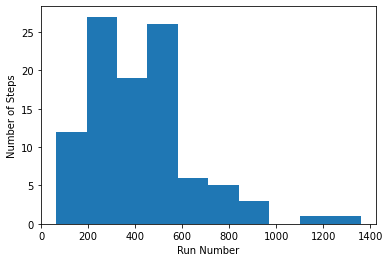

Floor Size:  10 x 10
Number of Runs:  100
Average Performance:  2917.86


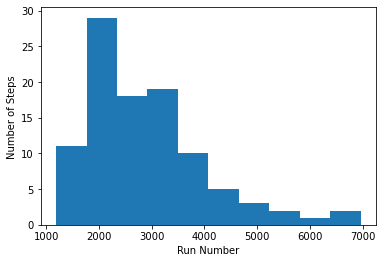

Floor Size:  100 x 100
Number of Runs:  100
Average Performance:  10000.0


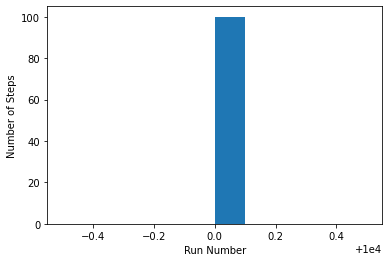

--------------------------------------------------------------------------------------------------------
Data for Simple Reflex Agent :

Floor Size:  5 x 5
Number of Runs:  100
Average Performance:  100.72


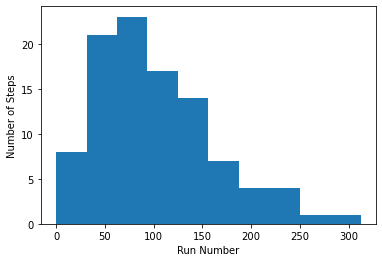

Floor Size:  10 x 10
Number of Runs:  100
Average Performance:  952.64


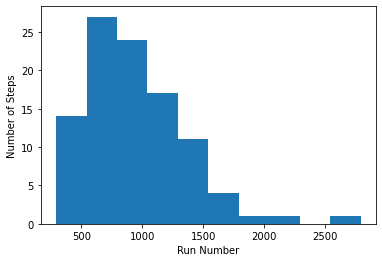

Floor Size:  100 x 100
Number of Runs:  100
Average Performance:  10000.0


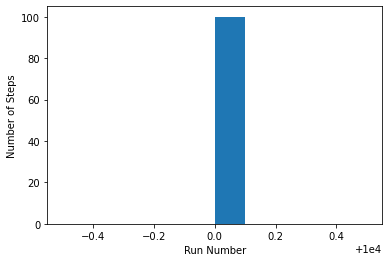

--------------------------------------------------------------------------------------------------------
Data for Model-Based Reflex Agent :

Floor Size:  5 x 5
Number of Runs:  100
Average Performance:  28.69


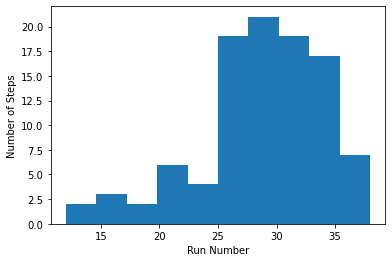

Floor Size:  10 x 10
Number of Runs:  100
Average Performance:  124.42


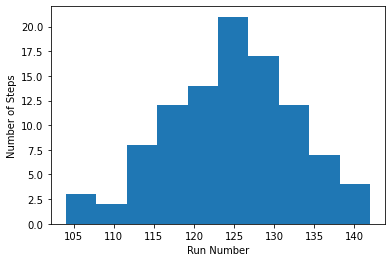

Floor Size:  100 x 100
Number of Runs:  100
Average Performance:  10000.0


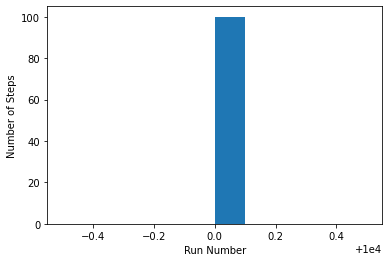

--------------------------------------------------------------------------------------------------------


In [134]:
graph()

Fill out the following table with the average performance measure for 100 random runs (you may also create this table with code):

| Size     | Randomized Agent | Simple Reflex Agent | Model-based Reflex Agent |
|----------|------------------|---------------------|--------------------------|
| 5x5     |423.42 | 100.72| 28.69|
| 10x10   |2917.86 | 952.64|124.42 |
| 100x100 | 10000| 10000|10000|

For all three agent types, as the number of floor squares increases, the number of steps needed to clean the whole foor increases as well. However, as the agent type gets more complex (randomized agent > simple reflex > model-based) the number of steps needed to clean the floor decreases significantly. Visually, the model-based reflex agent is able to clean the floor more quickly.

For all three agents, it could not clean the 100x100 floor in the max steps given (10000 steps).

## Task 5: Robustness of the agent implementations [1 Point] 

Describe how your agent implementations will perform 

* if it is put into a rectangular room with unknown size, 
* if the cleaning area can have an iregular shape (e.g., a hallway connecting two rooms), or 
* if the room contains obstacles (i.e., squares that it cannot pass through and trigger the bumper sensors).

- If put into a rectangular room with an unknown size, it would not have any issues because it relies on the bumpers of each wall to find the corner and when to change direction to clean the next row of squares. It does not rely on the floor size and shape.
- If it were to be placed into a room that is connected another through a hallway, it would miss any squares that are south of the opening to the hallway because the implementation works from top to bottom,
- If placed in a room of obstacles, the robot would navigate around the object cleaning the rows of squares north and south of the row that the object is located in, however, it would not clean the rest of the row after the object has been hit.

## Graduate student advanced task: Obstacles [1 Point]

__Undergraduate students:__ This is a bonus task you can attempt if you like [+1 Bonus point].

1. Change your simulation environment tor run experiments for the following problem: Add random obstacle squares that also trigger the bumper sensor. The agent does not know where the obstacles are. Observe how this changes the performance of the three implementations.

2. Describe what would need to be done to perform better with obstacles. Add code if you can. 

In [190]:
import random

def sim_environment_advanced(agent, n = 5, max_steps = 20, verbose = True):
    #randomize initial squares
    squares = np.random.choice(a = [False, True], size = (n, n), p = [.8, .2])
    
    #set random obstacles
    obstacles = []
    for i in range(len(squares)):
        row = []
        for j in range(len(squares[i])):
            if not squares[i][j]: #if not dirty
                row.append(random.sample([True, False], 2)) #randomly decide to put obstacle there or not
            else:
                row.append(False)
            
        obstacles.append(row)
    
    #choose random start position
    x = np.random.randint(n)
    y = np.random.randint(n)
    
    curr_step = 0
    while np.count_nonzero(squares) > 0 and curr_step < max_steps:
        bumpers = {
            'north': False,
            'south': False,
            'east': False,
            'west': False
        }
        
        # **Adding robot to respond to obstacles like bumpers**
        #horizantal coord.
        if x == 0 or obstacles[x - 1][y]:
            bumpers['north'] = True
        elif x == n - 1 or obstacles[x + 1][y]:
            bumpers['south'] = True
        #vertical coord.
        if y == 0 or obstacles[x][y - 1]:
            bumpers['west'] = True
        elif y == n - 1 or obstacles[x][y + 1]:
            bumpers['east'] = True
            
        dirty_square = squares[x][y]
        #call agent function
        agent_action = agent(bumpers, dirty_square)
        
        #react to agent action
        if verbose:
            print("Step ", curr_step, " - Position: (", x, ", ", y, ") - Action: ", agent_action)
        if agent_action == "suck":
            squares[x][y] = False
        elif agent_action == "north" and x != 0:
            x -= 1
        elif agent_action == "south" and x != n - 1: 
            x += 1
        elif agent_action == "east" and y != n - 1:
            y += 1
        elif agent_action == "west" and y != 0:
            y -= 1
            
        curr_step += 1
        
    return curr_step

In [191]:
#run for simple reflex agent
def graph_advanced():
    agent_types = ["Simple Randomized Agent", "Simple Reflex Agent", "Model-Based Reflex Agent"]
    floor_sizes = [5]
    num_runs = 100
    for a in range(len(agent_types)):
        run_data = np.repeat(0, num_runs)
        print("Data for", agent_types[a], ":\n")
        for n in floor_sizes:
            for i in range(num_runs):
                if a == 0:
                    run_data[i] = sim_environment_advanced(simple_randomized_agent, n, 10000, False)
                elif a == 1:
                    run_data[i] = sim_environment_advanced(simple_reflex_agent, n, 10000, False)
                elif a == 2:
                    mra = ModelReflexAgent()
                    run_data[i] = sim_environment_advanced(mra.act, n, 10000, False)

            #printing data
            print("Floor Size: ", n, "x", n)
            print("Number of Runs: ", num_runs)
            print("Average Performance: ", np.mean(run_data))

            #plotting data
            plt.hist(run_data, bins = 10)
            plt.xlabel("Run Number")
            plt.ylabel("Number of Steps")
            plt.show()
            
        print("--------------------------------------------------------------------------------------------------------")
        

Data for Simple Randomized Agent :

Floor Size:  5 x 5
Number of Runs:  100
Average Performance:  387.56


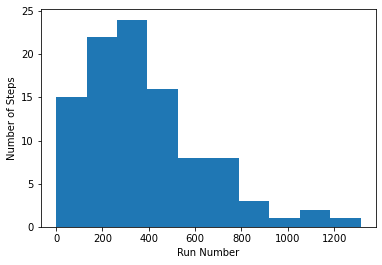

--------------------------------------------------------------------------------------------------------
Data for Simple Reflex Agent :

Floor Size:  5 x 5
Number of Runs:  100
Average Performance:  9700.69


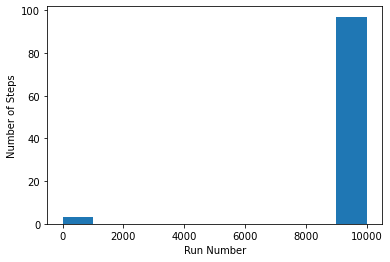

--------------------------------------------------------------------------------------------------------
Data for Model-Based Reflex Agent :

Floor Size:  5 x 5
Number of Runs:  100
Average Performance:  9600.27


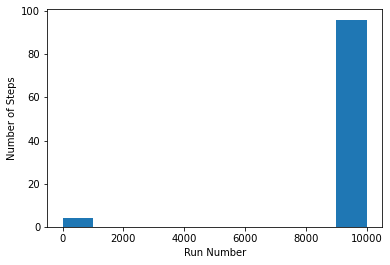

--------------------------------------------------------------------------------------------------------


In [192]:
graph_advanced()

1) Adding in obstacles to the floor plan significantly increases the number of steps needed to take for all agents to clean the floor, even for a small 5x5 floor. Both reflex agents aren't even able to clean before reaching the max amount of steps (10,000)
2) In order to operate better with obstacles, the robot should be able to keep track of where the obstacles are when it hits them, so it can avoid them the next time it is about to step onto the same square. Once the square is flagged as a bumper, the robot can trace the bumper to see if it is an obstacle (assuming the obstacle is always 1 square big) or a wall (more than one square). It can then return to its original location and then avoid it by keeping on the same path (changing direction and changing back to path) or changing directions entirely.

## More advanced tasks to think about

You can think about these:

* __Unknown environment with obstacles:__ Implement an agent for an environment where the agent does not know how large the environment is (we assume it is rectangular), where it starts or where the obstacles are. An option would be to always move to the closest unchecked/uncleaned square.

* __Utility-based agent:__ Change the environment, so each square has a fixed probability of getting dirty again. We assume the agent has learned this information over time. For the implementation, we give this information to the agent as a 2-dimensional array of probabilities  Cleaning one dirty square produces a utility of 1. Implement a utility-based agent that maximizes the expected utility over one full charge which lasts for 10000 time steps. This is very tricky!

In [13]:
# Your ideas/code